<a href="https://colab.research.google.com/github/EffiSciencesResearch/ML4G/blob/main/days/w1d4/gradCam/Grad_CAM_easy_mode_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we will introduce the Grad-CAM which visualizes the heatmap of input images by highlighting the important region for visual question answering(VQA) task.

* **To be submitted**: this notebook in two weeks, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.

* Make sure you are using the CPU mode in colab, otherwise, you will have some problems. This is important.


In [ ]:
!pip install jaxtyping einops -q

In [158]:
import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np

import torchvision.transforms as transforms
from PIL import Image
from jaxtyping import Float, Int

import matplotlib.pyplot as plt
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Visual Question Answering problem
Given an image and a question in natural language, the model choose the most likely answer from 3 000 classes according to the content of image. The VQA task is indeed a multi-classificaition problem.
<img src="https://github.com/EffiSciencesResearch/ML4G/blob/main/days/w1d4/gradCam/vqa_model.PNG?raw=1">

We provide you a pretrained model `vqa_resnet` for VQA tasks.

In [2]:
# Download necessary files
%cd /content
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TtuK5ZFDcnkK5qvF-ZBuY3PmAots6e7c' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TtuK5ZFDcnkK5qvF-ZBuY3PmAots6e7c" -O gradCam.zip && rm -rf /tmp/cookies.txt
! unzip -o gradCam.zip

/content
--2023-08-29 20:28:38--  https://docs.google.com/uc?export=download&confirm=t&id=1TtuK5ZFDcnkK5qvF-ZBuY3PmAots6e7c
Resolving docs.google.com (docs.google.com)... 108.177.126.101, 108.177.126.138, 108.177.126.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f27v6oene43ijarn3366e0t6d2u975s3/1693340850000/17628874696062005458/*/1TtuK5ZFDcnkK5qvF-ZBuY3PmAots6e7c?e=download&uuid=73f1551a-515d-4a89-9cc3-d87640f2e37b [following]
--2023-08-29 20:28:38--  https://doc-04-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f27v6oene43ijarn3366e0t6d2u975s3/1693340850000/17628874696062005458/*/1TtuK5ZFDcnkK5qvF-ZBuY3PmAots6e7c?e=download&uuid=73f1551a-515d-4a89-9cc3-d87640f2e37b
Resolving doc-04-94-docs.googleusercontent.com (doc-04-94-docs.googleusercontent.com)... 108

In [ ]:
# load model
%cd /content/gradCam
from load_model import load_model
vqa_resnet = load_model()

In [66]:
# Fixes a strange bug. Ideally, we would run the model in eval mode though.
vqa_resnet.train()
# Dropout of 0.5 is too big, for deterministic behavior, remove the dropout

# Loop through all the modules in the model
for module in vqa_resnet.modules():
    if isinstance(module, nn.Dropout):
        # Update the dropout probability for each dropout layer
        module.p = 0.0

The model uses to sets of tokens, which are all words, one for the questions and one for the answers. 

In [21]:
checkpoint = '2017-08-04_00.55.19.pth'
saved_state = torch.load(checkpoint, map_location=device)
# reading vocabulary from saved model
vocab = saved_state['vocab']
print("Vocab:", set(vocab.keys()))

# reading word tokens from saved model
question_word_to_index = vocab['question']
print("Tokens for questions:", question_word_to_index)

# reading answers from saved model
answer_word_to_index = vocab['answer']
print("Tokens for answers:", answer_word_to_index)

num_tokens = len(question_word_to_index) + 1
print(f"{num_tokens=}")

# Mapping from integer to token string
index_to_answer_word = ['unk'] * len(answer_word_to_index)
for w, idx in answer_word_to_index.items():
    index_to_answer_word[idx]=w

print(index_to_answer_word)

Vocab: {'question', 'answer'}
Tokens for questions: {'the': 1, 'is': 2, 'what': 3, 'are': 4, 'this': 5, 'in': 6, 'on': 7, 'a': 8, 'of': 9, 'how': 10, 'many': 11, 'color': 12, 'there': 13, 'does': 14, 'man': 15, 'people': 16, 'to': 17, 'picture': 18, 'wearing': 19, 'it': 20, 'these': 21, 'where': 22, 'have': 23, 'kind': 24, 'or': 25, 'person': 26, 'photo': 27, 'do': 28, 'you': 29, 'doing': 30, 'type': 31, 'animal': 32, 'woman': 33, 'they': 34, 'room': 35, 'be': 36, 'holding': 37, 'animals': 38, 'for': 39, 'can': 40, 'dog': 41, 'at': 42, 'cat': 43, 'train': 44, 'that': 45, 'his': 46, 'sign': 47, 'he': 48, 'which': 49, 'water': 50, 'any': 51, 'food': 52, 'bus': 53, 'why': 54, 'shirt': 55, 'an': 56, 'see': 57, 'playing': 58, 'made': 59, 'sitting': 60, 'with': 61, 'plane': 62, 'plate': 63, 'sport': 64, 'shown': 65, "man's": 66, 'time': 67, 'table': 68, 'taken': 69, 'right': 70, 'left': 71, 'was': 72, 'number': 73, 'background': 74, 'standing': 75, 'white': 76, 'pizza': 77, 'who': 78, 'being

### Inputs
In order to use the pretrained model, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(448, 448)`. You can call the function `image_to_features` to achieve image preprocessing. For input question, the function `encode_question` is provided to encode the question into a vector of indices. You can also use `preprocess` function for both image and question preprocessing.

In [23]:
def get_transform():
    target_size = 448
    central_fraction = 1.0
    return transforms.Compose([
        transforms.Resize(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

In [24]:
def encode_question(question: str) -> tuple[Int[Tensor, "nb_words"], int]:
    """Turn a question into a vector of tokens and a question length."""
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = question_word_to_index.get(token, 0)
        vec[i] = index
    return vec, len(question_arr)

In [25]:
def preprocess(dir_path: str, question: str):
    """
    Load the image at `dir_path` and process it to be a suitable input for vqa_resnet.
    """
    q, q_len = encode_question(question)
    img = Image.open(dir_path).convert('RGB')
    transform = get_transform()
    img_transformed = transform(img)
    img_features = img_transformed.unsqueeze(0).to(device)
    q_len = torch.tensor(q_len, device=device)

    inputs = (img_features, q.unsqueeze(0), q_len.unsqueeze(0))
    return inputs

In [81]:
def check_answers(img_path: str, question: str):
    # Check the answers of the model
    inputs = preprocess(img_path, question)
    ans = vqa_resnet(*inputs)
    probas = F.softmax(ans.squeeze(), dim=0)
    values, tokens_indices = torch.topk(probas, k=10)

    print("Output probablities")
    for token, value in zip(tokens_indices, values):
        print(index_to_answer_word[token], f"-> {value:.2%}")


We provide you two pictures and some question-answers.

Output probablities
giraffe -> 68.74%
dog -> 26.11%
1 -> 4.55%
2 -> 0.22%
goat -> 0.13%
cow -> 0.09%
horse -> 0.06%
yes -> 0.04%
elephant -> 0.02%
cat -> 0.01%


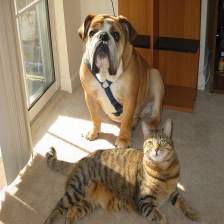

In [116]:
img1 = 'dog_cat.png'   # TODO: rename every variable.
Question1 = 'What animal'
Answer1 = ['dog','cat' ]
# We find tokenizisation of dog and cat
indices1 = [answer_word_to_index[ans] for ans in Answer1]
check_answers(img1, Question1)
Image.open(img1)

Since we deactivated

Output probablities
green -> 97.99%
gray -> 1.22%
blue -> 0.36%
red -> 0.22%
brown -> 0.12%
black -> 0.05%
white -> 0.02%
black and white -> 0.01%
orange -> 0.01%
yellow -> 0.00%


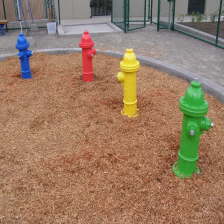

In [117]:
img2 = 'hydrant.png'
Question2 = 'What color'
Answer2 = ['green','yellow' ]
indices2 = [answer_word_to_index[ans] for ans in Answer2]
check_answers(img2, Question2)

Image.open(img2)

### Hooks in  pytorch

The goal of this exercise is to familiarize yourself with the hook system in pytorch. The hooks are not used to manipulate the weights but to **manipulate the activations** of the model on a given input. You can read, and even modify the hidden activations of the model

1. Use hooks to log information about the inner working of the model. Here we will just print the shapes of the activations.
2. But we can also view more interesting information. In the second exercise we plot the norm of each channel. The norm of a channel is a (bad) proxy for how much information there is in a channel.
3. We actually modify the activation to flip the sign of the output of a convolution. This should change the output of our model: we are butchering through it! (this is also a completely meaningless operation, but let's see what it does...)

Hooks in pytorch are not super pleasant to work with:
- Once you add
- Inputs are tuples
- Errors

We do our interventions in the second to last convolution of the resnet, defined bellow.

You may need to read the hook tuto https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks

In [76]:
# Second to last convolution
module_to_hook =  vqa_resnet.resnet_layer4.r_model.layer4[2].conv3

In [118]:
# Exercise 1: find the shapes of the input and output of the second to last convolution
# Note: both of them are 4D.

def show_shapes_hook(self, inputs, outputs):
    ...
    print(f"{inputs[0].shape=}")
    print(f"{outputs.shape=}")

hook_handle = module_to_hook.register_forward_hook(show_shapes_hook)

try:
    check_answers(img1, Question1)
finally:
    hook_handle.remove()

inputs[0].shape=torch.Size([1, 512, 14, 14])
outputs.shape=torch.Size([1, 2048, 14, 14])
Output probablities
giraffe -> 68.74%
dog -> 26.11%
1 -> 4.55%
2 -> 0.22%
goat -> 0.13%
cow -> 0.09%
horse -> 0.06%
yes -> 0.04%
elephant -> 0.02%
cat -> 0.01%


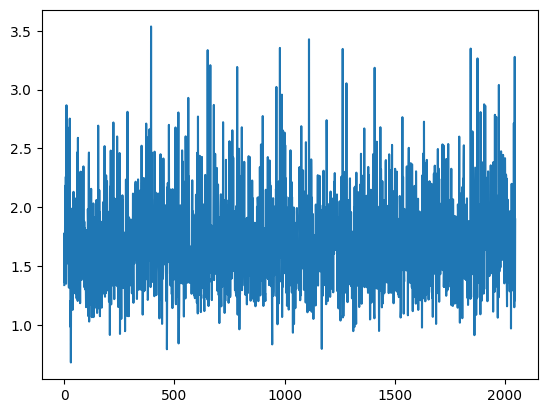

Output probablities
giraffe -> 68.74%
dog -> 26.11%
1 -> 4.55%
2 -> 0.22%
goat -> 0.13%
cow -> 0.09%
horse -> 0.06%
yes -> 0.04%
elephant -> 0.02%
cat -> 0.01%


In [130]:
# Exercise 2: figuring out which channels have the highest norm (≈ are the most used)
# What does the plot tells you about the inner workings of the model?

def plot_highest_output_norm(self, inputs, outputs):
    norms = ...
    norms = torch.linalg.vector_norm(outputs, dim=(0, 2, 3))

    norms.squeeze_()
    assert norms.shape == (2048,)
    plt.plot(norms.detach().cpu())
    plt.show()

hook_handle = module_to_hook.register_forward_hook(plot_highest_output_norm)

try:
    check_answers(img1, Question1)
finally:
    hook_handle.remove()

In [131]:
# Exercise 3: What would happen if we filp the contribution of this convolution to the residual stream?
# Make a prediction first!

def flip_output(self, inputs, outputs):
    # You need to modify output *in place*
    ...
    outputs *= -1

hook_handle = module_to_hook.register_forward_hook(flip_output)

try:
    check_answers(img1, Question1)
finally:
    hook_handle.remove()


Output probablities
dog -> 50.62%
giraffe -> 35.44%
1 -> 10.29%
2 -> 1.59%
cat -> 1.27%
yes -> 0.20%
horse -> 0.19%
no -> 0.15%
goat -> 0.13%
cow -> 0.06%


In [141]:
# Exercise 4: Save the output activations so we can re-use them later.

saved_output = None
saved_output_grad = None

def forward_hook(self, inputs, output):
    global saved_output
    saved_output = output
    print("Saved output of shape:", output.shape)

def backward_hook(self, grad_input, grad_outputs):
    global saved_output_grad
    saved_output_grad  = grad_outputs[0]
    print("Saved gradient of shape:", grad_outputs[0].shape)

# What does global means in python?
# Why do we need global?


forward_handle = module_to_hook.register_forward_hook(forward_hook)
backward_handle = module_to_hook.register_backward_hook(backward_hook)

try:
    inputs = preprocess(img1, Question1)
    vqa_resnet.zero_grad()
    ans = vqa_resnet(*inputs)
    # Pretend the loss is the 'giraffe' logit.
    loss = ans[0, 0]
    loss.backward()  # TODO: change for giraffe
finally:
    forward_handle.remove()
    backward_handle.remove()

print("Shape of saved output:", saved_output.shape)
print("Shape of saved grad:", saved_output_grad.shape)


Saved output of shape: torch.Size([1, 2048, 14, 14])
Saved gradient of shape: torch.Size([1, 2048, 14, 14])
Shape of saved output: torch.Size([1, 2048, 14, 14])
Shape of saved grad: torch.Size([1, 2048, 14, 14])


### Grad-CAM
* **Overview:** Given an image with a question, and a category (‘dog’) as input, we forward propagate the image through the model to obtain the `raw class scores` before softmax. We backpropagate only the logit of the target class. This signal is then backpropagated to the `convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* We will define a `grad_cam` function visualize each image and its saliency map.

* **Hints**:  # TODO: on y revient!
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully.
 + The pretrained model `vqa_resnet` doesn't have the activation function after its last layer, the output is indeed the `raw class scores`, you can use it directly. Run "print(vqa_resnet)" to get more information on VGG model.
 + The last CNN layer of the model is: `vqa_resnet.resnet_layer4.r_model.layer4[2].conv3`
 + The size of feature maps is 14x14, so as your heatmap. You need to project the heatmap to the original image(224x224) to have a better observation. The function `cv2.resize()` may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

<img src="https://github.com/EffiSciencesResearch/ML4G/blob/main/days/w1d4/gradCam/grad_cam.png?raw=1">

In [162]:
def gradCAM(dir_path = 'dog_cat.png' , Question = 'What animal', answer = "dog", module_to_hook = module_to_hook):
    # Make a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))
    # Plot the original image on the left
    img = Image.open(dir_path)
    axs[0].imshow(img)
    axs[0].set_title("Original image")

    inputs = preprocess(dir_path, Question)
    vqa_resnet.zero_grad()

    forward_handle = module_to_hook.register_forward_hook(forward_hook)
    backward_handle = module_to_hook.register_backward_hook(backward_hook)

    try:
        ans = vqa_resnet(*inputs)

        # Backpropagating just on the dog or the given answer
        only_class_ans = ans[0, answer_word_to_index[answer]]
        only_class_ans.backward()
    finally:
        forward_handle.remove()
        backward_handle.remove()

    # Construction of the grad_cam map
    # nb_features = saved_output.shape[1]
    # for i in range(nb_features):
    #     # We take the mean of each feature of the gradient multiplied by the output
    #     # use output_saving and grad_output_saving to complete the following line.
    #     # You have to understand eq. 1 and 2 in the paper.
    #     # grad_cam += ...
    #     grad_cam += torch.mean(saved_output_grad[0,i,:,:]) * saved_output[0, i,:,:]
    mean_gradient = einops.reduce(saved_output_grad, "batch features w h -> features", "mean")
    grad_cam = einops.einsum(mean_gradient, saved_output.squeeze(0), "features, features w h -> w h")

    Relu = nn.ReLU()
    grad_cam = Relu(grad_cam)
    grad_cam = grad_cam.cpu().detach().numpy()

    cam = cv2.resize(grad_cam, (224, 224))
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
    cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize

    # Heatmap of activation map
    activation_heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_HSV)
    axs[1].imshow(activation_heatmap)
    axs[1].set_title("Heatmap of activation map")

    # Heatmap on picture
    img = cv2.imread(dir_path)
    org_img = cv2.resize(img, (224, 224))
    img_with_heatmap = np.float32(activation_heatmap) + np.float32(org_img)
    img_with_heatmap *= 0.99/ np.max(img_with_heatmap)
    axs[2].imshow(img_with_heatmap)
    axs[2].set_title("Heatmap on picture")

    plt.show()

Saved output of shape: torch.Size([1, 2048, 14, 14])
Saved gradient of shape: torch.Size([1, 2048, 14, 14])


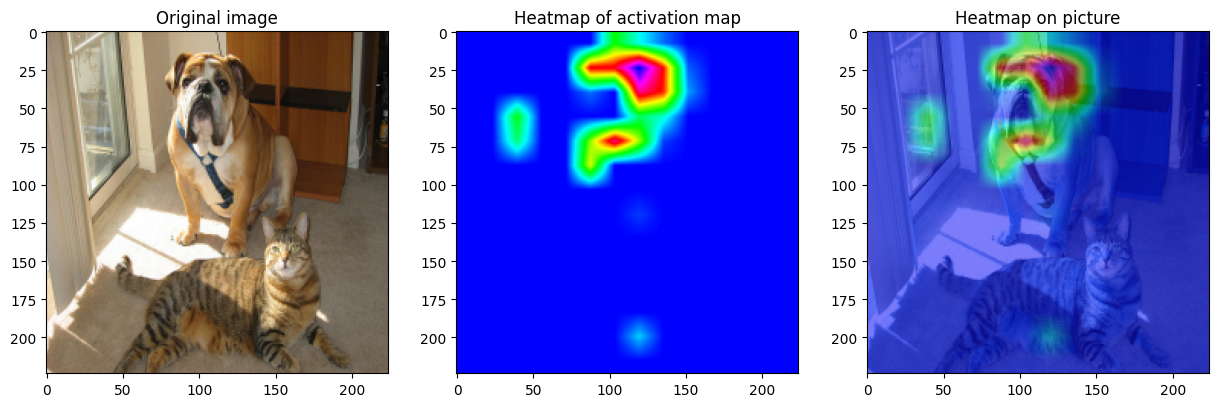

In [163]:
gradCAM(dir_path = 'dog_cat.png' , Question = 'What animal', answer = "dog")

Saved output of shape: torch.Size([1, 2048, 14, 14])
Saved gradient of shape: torch.Size([1, 2048, 14, 14])


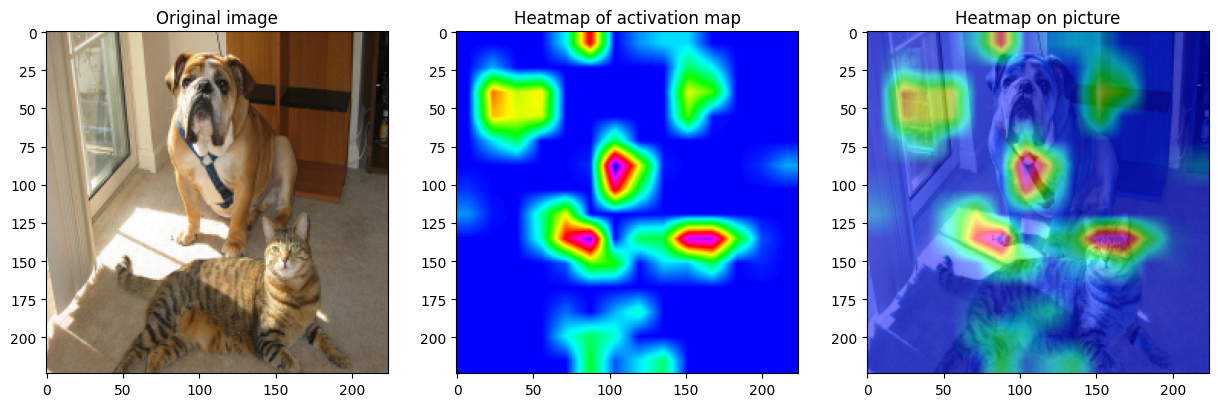

In [164]:
gradCAM(dir_path = 'dog_cat.png' , Question = 'What animal', answer = "cat")

Saved output of shape: torch.Size([1, 2048, 14, 14])
Saved gradient of shape: torch.Size([1, 2048, 14, 14])


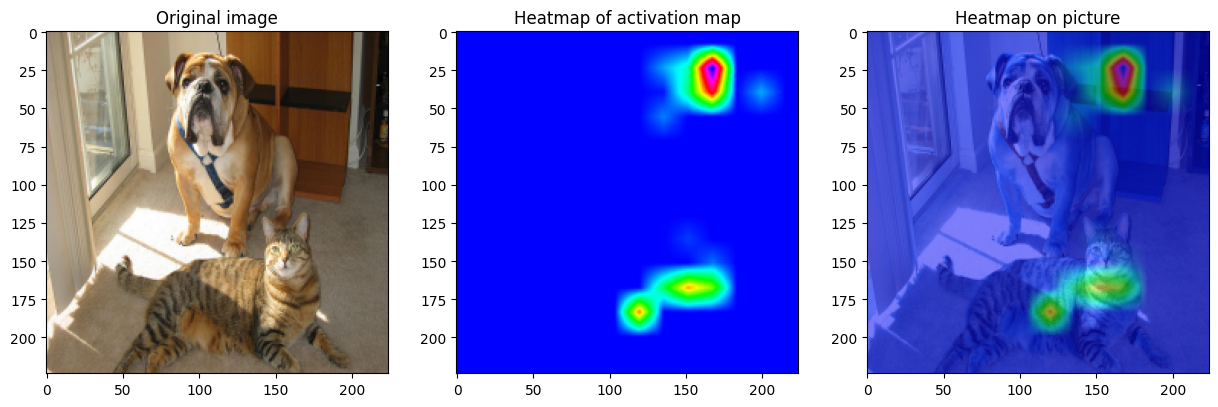

In [165]:
gradCAM(dir_path = 'dog_cat.png' , Question = 'What animal', answer = "giraffe")


Saved output of shape: torch.Size([1, 2048, 14, 14])
Saved gradient of shape: torch.Size([1, 2048, 14, 14])


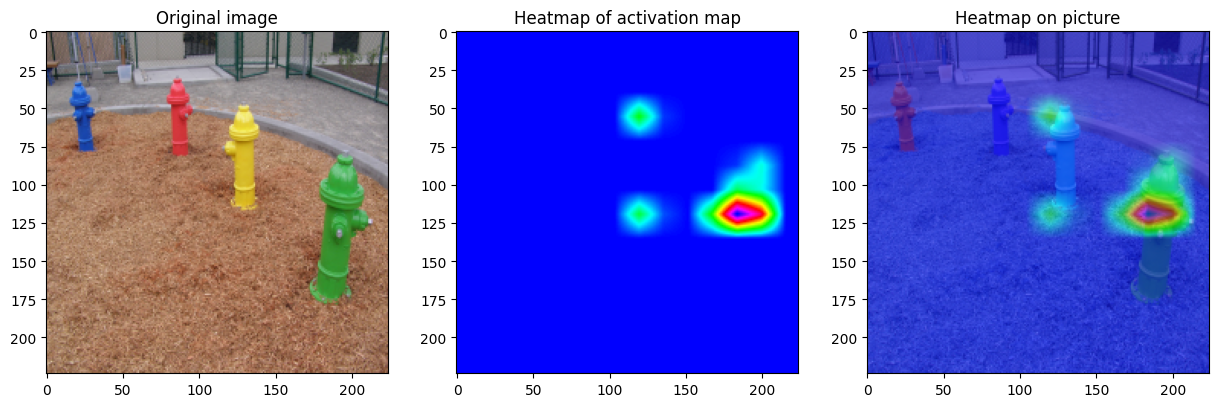

In [166]:
gradCAM(dir_path = 'hydrant.png' , Question = 'What color', answer = "green")

Saved output of shape: torch.Size([1, 2048, 14, 14])
Saved gradient of shape: torch.Size([1, 2048, 14, 14])


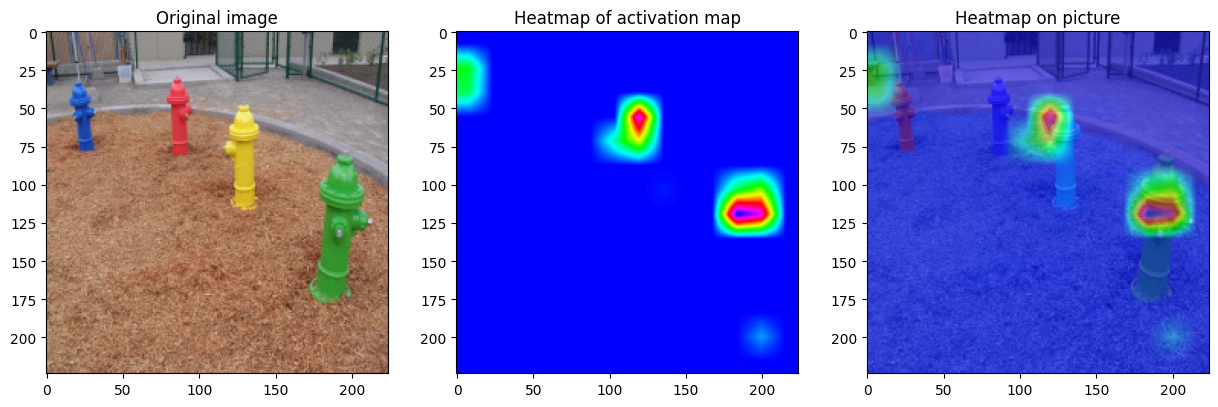

In [152]:
gradCAM(dir_path = 'hydrant.png' , Question = 'What color', answer = "yellow")

Interpretation ?